# **DESCRIPTION**

This project consists of a segmentation of a company's customers according to the number of orders already placed, the amount of these orders and the number of equipment purchased.

Companies names have been changed in order to protect the privacy of the data

# **Project Develop**

## *Install libraries*

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## *Import data from Excel file*

In [2]:
raw_data = pd.read_excel('ORDERS.xlsx')
raw_data.head()

,num_order,order_date,customer,nac_ext,order_amount,items_number
0,P-08/020-S00,2008-01-22,Cliente_1,Nacional,1222.30,20
1,P-08/030-S00,2008-02-07,Cliente_2,Nacional,11260.08,28
2,P-08/039-S00,2008-02-15,Cliente_3,Nacional,13970.92,81
3,P-08/044-S00,2008-02-19,Cliente_4,Nacional,2131.32,55
4,P-08/069-S00,2008-04-23,Cliente_4,Nacional,75429.25,246


## *Cleaning data*

In [3]:
raw_data['order_amount'] = raw_data['order_amount'].astype(float)
raw_data.drop(columns=['order_date'])

,num_order,customer,nac_ext,order_amount,items_number
0,P-08/020-S00,Cliente_1,Nacional,1222.30,20
1,P-08/030-S00,Cliente_2,Nacional,11260.08,28
2,P-08/039-S00,Cliente_3,Nacional,13970.92,81
3,P-08/044-S00,Cliente_4,Nacional,2131.32,55
4,P-08/069-S00,Cliente_4,Nacional,75429.25,246
...,...,...,...,...,...
2477,PA-25/029,Cliente_131,Exterior,1260.00,2
2478,PA-25/030,Cliente_7,Nacional,500.00,1
2479,PA-25/031,Cliente_177,Nacional,740.00,2
2480,PA-25/032,Cliente_26,Exterior,1610.00,1


## *Grouping data*

Separating by national and international

In [4]:
data_national = raw_data[raw_data['nac_ext'] == 'Nacional'].copy()
data_international = raw_data[raw_data['nac_ext'] == 'Exterior'].copy()

Grouping by customer

In [5]:
segments_national = data_national.groupby('customer').agg({'num_order':'count', # Total orders
                                            'order_amount': 'sum', # Total amount of orders
                                            'items_number': 'mean' # Mean item by order
                                            }).rename(columns={"num_order": "Total Pedidos",
                                                               "order_amount": "Importe Total €",
                                                               "items_number": "Promedio Equipos"
                                                               }).reset_index()

In [6]:
segments_international = data_international.groupby('customer').agg({'num_order':'count', # Total orders
                                            'order_amount': 'sum', # Total amount of orders
                                            'items_number': 'mean' # Mean item by order
                                            }).rename(columns={'num_order': 'Total Pedidos',
                                                               'order_amount': 'Importe Total €',
                                                               'items_number': 'Promedio Equipos'
                                                               }).reset_index()

## *Segmentation*

In [7]:
# Selecting features
features_national = segments_national[['Total Pedidos', 'Importe Total €', 'Promedio Equipos']]

# Standarization
scaler = StandardScaler()
scaled_features_national = scaler.fit_transform(features_national)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
segments_national['Cluster'] = kmeans.fit_predict(scaled_features_national)

In [8]:
# Selecting features
features_international = segments_international[['Total Pedidos', 'Importe Total €', 'Promedio Equipos']]

# Standarization
scaler = StandardScaler()
scaled_features_international = scaler.fit_transform(features_international)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
segments_international['Cluster'] = kmeans.fit_predict(scaled_features_international)

## *Visualizing results*

### NATIONAL

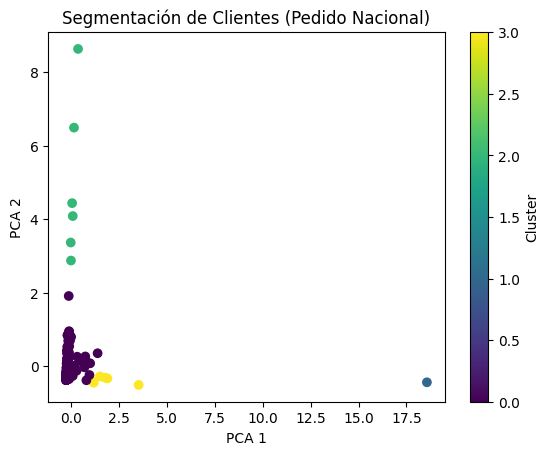

In [9]:
pca=PCA(n_components=2)
reduce_features_national=pca.fit_transform(scaled_features_national)

plt.scatter(reduce_features_national[:,0], reduce_features_national[:,1], c=segments_national['Cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("Segmentación de Clientes (Pedido Nacional)")
plt.colorbar(label="Cluster")
plt.show()


**Graph Analysis**

*   Cluster 0: low number of orders, low total amount and buy few items
*   Cluster 1: many orders and very high total amount
*   Cluster 2: occasional large orders
*   Cluster 3: low quantity of orders but high total amount





Evaluation using WCSS

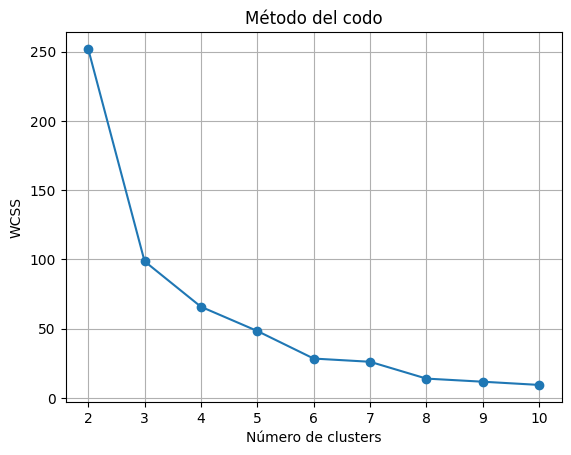

In [10]:
wcss = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_national)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

# Graph the elbow
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del codo')
plt.grid(True)
plt.show()


Evaluation using Silhouette

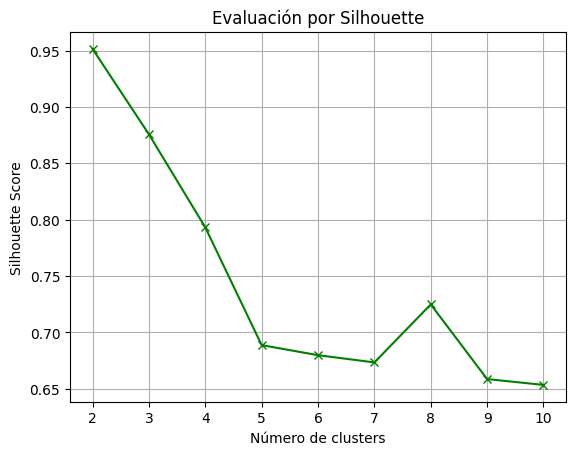

In [11]:
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features_national)
    score = silhouette_score(scaled_features_national, labels)
    silhouette_scores.append(score)

# Graph Silhouette
plt.plot(k_values, silhouette_scores, marker='x', color='green')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Evaluación por Silhouette')
plt.grid(True)
plt.show()


The following conclusions can be drawn from both graphs:
*   For simplicity and compactness, better solution is k = 2
*   For a balance between good structure and detail, k=3 or k=4 are more appropiate

Final selection is **k=4** due to it has a good WCSS (stable zone), high Silhouette score (~0.79) and it provides more differentiation




In [12]:
# Print data for each cluster
print(segments_national.groupby("Cluster").agg({
    "Total Pedidos": "mean",
    "Importe Total €": "mean",
    "Promedio Equipos": "mean"
}))

         Total Pedidos  Importe Total €  Promedio Equipos
Cluster                                                  
0             5.010695     1.013379e+05         16.672798
1           611.000000     2.988584e+07         66.155483
2             2.000000     1.104797e+05        350.583333
3           117.500000     1.169149e+06         10.144517


In [13]:
# Print data for premium customer
customers_premium = segments_national[segments_national['Cluster'] == 1]
print(customers_premium)

       customer  Total Pedidos  Importe Total €  Promedio Equipos  Cluster
132  Cliente_38            611      29885842.55         66.155483        1


### INTERNATIONAL

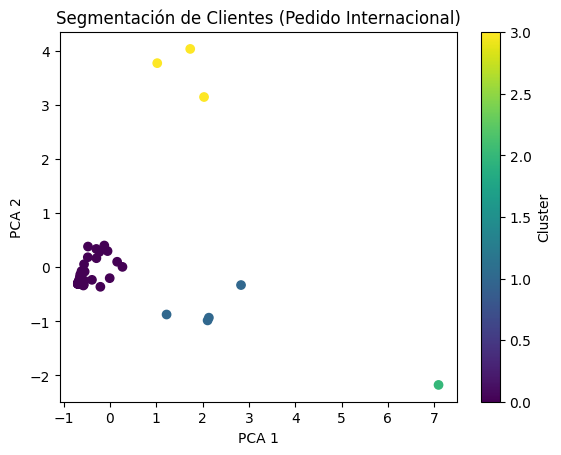

In [14]:
pca=PCA(n_components=2)
reduce_features_international=pca.fit_transform(scaled_features_international)

plt.scatter(reduce_features_international[:,0], reduce_features_international[:,1], c=segments_international['Cluster'], cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("Segmentación de Clientes (Pedido Internacional)")
plt.colorbar(label="Cluster")
plt.show()

**Graph Analysis**

*   Cluster 0: occasional large orders
*   Cluster 1: low number of orders, low total amount and buy few items
*   Cluster 2: low-frequency large orders
*   Cluster 3: many orders and very high total amount

Evaluation using WCSS

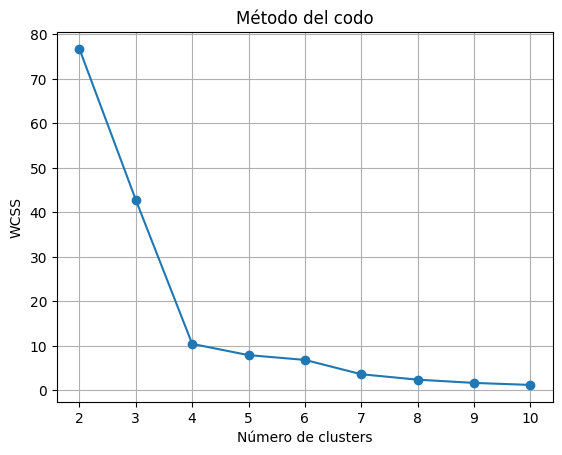

In [15]:
wcss = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features_international)
    wcss.append(kmeans.inertia_)  # inertia_ is WCSS

# Graph the elbow
plt.plot(k_values, wcss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del codo')
plt.grid(True)
plt.show()


Evaluation using Silhouette

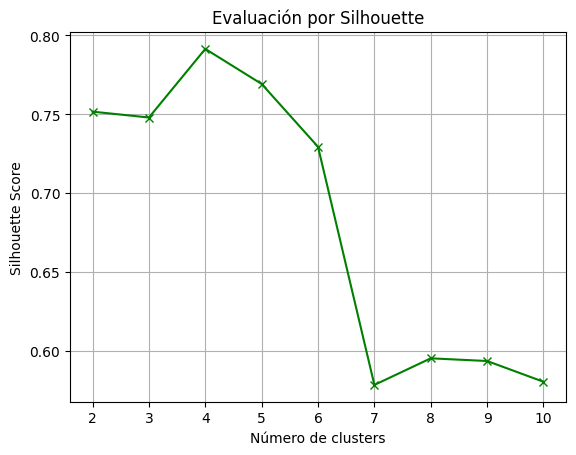

In [16]:
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features_international)
    score = silhouette_score(scaled_features_international, labels)
    silhouette_scores.append(score)

# Graph Silhouette
plt.plot(k_values, silhouette_scores, marker='x', color='green')
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette Score')
plt.title('Evaluación por Silhouette')
plt.grid(True)
plt.show()

As in the case of National, the same conclusions can be drawn from both graphs:
*   For simplicity and compactness, better solution is k = 2
*   For a balance between good structure and detail, k=3 or k=4 are more appropiate

Final selection is **k=4** due to it has a good WCSS (stable zone), high Silhouette score (~0.79) and it provides more differentiation


In [17]:
# Print data for each cluster
print(segments_international.groupby("Cluster").agg({
    "Total Pedidos": "mean",
    "Importe Total €": "mean",
    "Promedio Equipos": "mean"
}))

         Total Pedidos  Importe Total €  Promedio Equipos
Cluster                                                  
0             1.525000     3.054670e+04         12.118750
1            21.750000     3.831731e+05         10.568761
2            65.000000     1.003241e+06          8.061538
3             1.333333     3.598919e+05        248.500000


In [18]:
# Print data for premium customer
customers_premium = segments_international[segments_international['Cluster'] == 3]
print(customers_premium)

       customer  Total Pedidos  Importe Total €  Promedio Equipos  Cluster
5   Cliente_161              1        200760.00             259.0        3
9   Cliente_178              2        500036.34             214.5        3
30  Cliente_216              1        378879.38             272.0        3


With all this information, the company can start preparing and executing marketing actions and commercial strategies to improve its sales with existing customers.